In [4]:
import os
from qiime2 import Visualization, Artifact, Metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
# create output dir
if not os.path.isdir("output/"):
    os.mkdir("output/")
    for dir_name in ["qza", "qzv", "table", "plot", "json"]:
        os.mkdir(os.path.join("output", dir_name))

In [5]:
# import fastq.gz
seq_path = "seq"

if not os.path.isfile("output/qza/raw_seqs.qza"):
    raw_seqs = Artifact.import_data("SampleData[PairedEndSequencesWithQuality]", 
                                    f"./{seq_path}/", 
                                    "CasavaOneEightSingleLanePerSampleDirFmt")
    raw_seqs.save("output/qza/raw_seqs")
else:
    raw_seqs = Artifact.load("output/qza/raw_seqs.qza")


In [4]:
# QC info
from qiime2.plugins.demux.visualizers import summarize 
seqs_summarize = summarize(raw_seqs)[0] # 用於判斷定序品質
seqs_summarize.save("output/qzv/seqs_summarize") # save qzv
seqs_summarize.export_data("output/seqs_summarize")
seqs_summarize

/home/blue_pc/miniconda3/envs/qiime2/lib/python3.8/site-packages/q2_demux/_summarize/_visualizer.py:191: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  context['result_data'] = context['result_data'].append(df)
/home/blue_pc/miniconda3/envs/qiime2/lib/python3.8/site-packages/q2_demux/_summarize/_visualizer.py:191: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  context['result_data'] = context['result_data'].append(df)


<visualization: Visualization uuid: b2e39e86-7d40-4aad-8354-820e3ff33cfe>

<Figure size 640x480 with 0 Axes>

In [6]:
# dada2 denoise 
# 請參考上面資料來決定切除到哪個位置
from qiime2.plugins.dada2.methods import denoise_paired # dada2去雜訊
trunc_len = 270
trim = 15
feature_table, representative_seqs, denoising_stats = denoise_paired(raw_seqs, 
                                              trunc_len_f = trunc_len,
                                              trunc_len_r = trunc_len, 
                                              trim_left_f = trim, 
                                              trim_left_r = trim,
                                              n_threads = 0,
                                              )

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada.R --input_directory /tmp/tmphjofzvni/forward --input_directory_reverse /tmp/tmphjofzvni/reverse --output_path /tmp/tmphjofzvni/output.tsv.biom --output_track /tmp/tmphjofzvni/track.tsv --filtered_directory /tmp/tmphjofzvni/filt_f --filtered_directory_reverse /tmp/tmphjofzvni/filt_r --truncation_length 270 --truncation_length_reverse 270 --trim_left 15 --trim_left_reverse 15 --max_expected_errors 2.0 --max_expected_errors_reverse 2.0 --truncation_quality_score 2 --min_overlap 12 --pooling_method independent --chimera_method consensus --min_parental_fold 1.0 --allow_one_off False --num_threads 0 --learn_min_reads 1000000

R version 4.1.3 (2022-03-10) 


Loading required package: Rcpp


DADA2: 1.22.0 / Rcpp: 1.0.9 / RcppParallel: 5.1.5 
2) Filtering 

The filter removed all reads: /tmp/tmphjofzvni/filt_f/1_S11_L001_R1_001.fastq.gz and /tmp/tmphjofzvni/filt_r/1_S11_L001_R2_001.fastq.gz not written.
Some input samples had no reads pass the filter.


x..........................
3) Learning Error Rates
268440285 total bases in 1052707 reads from 9 samples will be used for learning the error rates.
268440285 total bases in 1052707 reads from 9 samples will be used for learning the error rates.
3) Denoise samples ..........................
..........................
5) Remove chimeras (method = consensus)
6) Report read numbers through the pipeline
7) Write output


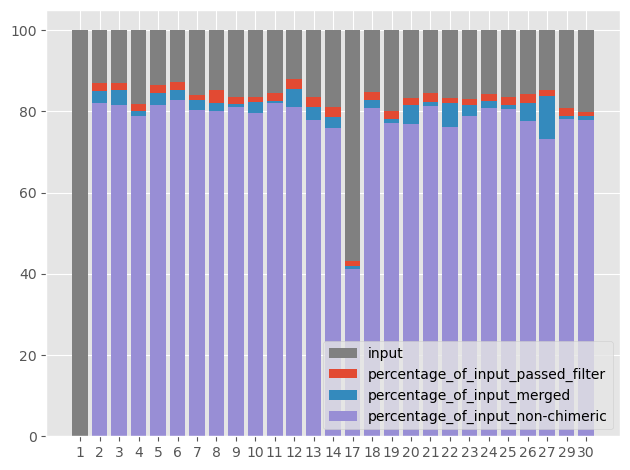

In [7]:
# stats_df
stats_df = denoising_stats.view(Metadata).to_dataframe()
stats_df.columns = pd.Series(stats_df.columns).apply(lambda x: x.replace(" ", "_"))
stats_df.index = pd.Series(stats_df.index).apply(lambda x: x.split("_", 1)[0]).astype(np.int64).sort_values()
stats_df.to_csv(f"output/table/stats_df_{trunc_len}_{trim}.csv")

# stats bar plot
fig, ax = plt.subplots(1, 1)

ax.bar(range(len(stats_df.index)), 100, color="gray", label="input")
for bar_title in ["percentage_of_input_passed_filter", "percentage_of_input_merged", "percentage_of_input_non-chimeric"]:
    ax.bar(range(len(stats_df.index)), stats_df.loc[:, bar_title], label= bar_title)
plt.xticks(range(len(stats_df.index)), stats_df.index)
ax.legend(loc='lower right')
fig.tight_layout()
fig.show()
fig.savefig(f"output/plot/stats_df_bar_plot_{trunc_len}_{trim}.png", format='png', bbox_inches='tight', dpi=600) # 透明背景


In [8]:
# save data
feature_table.save("output/qza/feature_table")
# biom format
feature_table.export_data("output/table")
representative_seqs.save("output/qza/representative_seqs")
representative_seqs.export_data("output/representative_seqs")
denoising_stats.save("output/qza/denoising_stats")

'output/qza/denoising_stats.qza'

In [14]:
asv = feature_table.view(pd.DataFrame)
asv = asv.sort_index()
asv = asv.T
asv.to_csv("output/table/asv.csv")

In [ ]:
representative_seqs = Artifact.load("/home/blue_pc/code/CYH/output/qza/representative_seqs.qza")

In [9]:
silva = Artifact.load("/home/blue_pc/ref/silva-138-99-515-806-nb-classifier.qza")
from qiime2.plugins.feature_classifier.methods import classify_sklearn
SKLEARN_USE_ALL_CPU = -2
classification = classify_sklearn(reads=representative_seqs, classifier=silva, n_jobs=SKLEARN_USE_ALL_CPU)
classification.save("output/qza/classification")

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11)}

In [10]:
from qiime2.plugins.phylogeny.pipelines import align_to_tree_mafft_fasttree
alignment, masked_alignment, tree, rooted_tree  = align_to_tree_mafft_fasttree(representative_seqs)
# save 
alignment.save("output/qza/alignment") 
masked_alignment.save("output/qza/masked_alignment")
tree.save("output/qza/tree")
rooted_tree.save("output/qza/rooted_tree")

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /tmp/qiime2/blue_pc/data/16c50de6-da6f-471b-9d52-f76734188c55/data/dna-sequences.fasta



inputfile = orig
2242 x 496 - 256 d
nthread = 1
nthreadpair = 1
nthreadtb = 1
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 2201 / 2242 (thread    0)
done.

Constructing a UPGMA tree (efffree=0) ... 
 2240 / 2242
done.

Progressive alignment 1/2... 
STEP  2001 / 2241 (thread    0)
Reallocating..done. *alloclen = 2024
STEP  2201 / 2241 (thread    0)
Reallocating..done. *alloclen = 3117

done.

Making a distance matrix from msa.. 
 2200 / 2242 (thread    0)
done.

Constructing a UPGMA tree (efffree=1) ... 
 2240 / 2242
done.

Progressive alignment 2/2... 
STEP  2101 / 2241 (thread    0)
Reallocating..done. *alloclen = 2007
STEP  2201 / 2241 (thread    0)
Reallocating..done. *alloclen = 3079

done.

disttbfast (nuc) Version 7.505
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
1 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (gu

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /tmp/qiime2/blue_pc/data/1e359016-dfc8-4f7f-9bec-cca85e7b33f7/data/aligned-dna-sequences.fasta



FastTree Version 2.1.11 Double precision (No SSE3)
Alignment: /tmp/qiime2/blue_pc/data/1e359016-dfc8-4f7f-9bec-cca85e7b33f7/data/aligned-dna-sequences.fasta
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jukes-Cantor, CAT approximation with 20 rate categories
      0.27 seconds: Top hits for    374 of   2078 seqs (at seed    100)
      0.38 seconds: Top hits for    707 of   2078 seqs (at seed    400)
      0.49 seconds: Top hits for   1068 of   2078 seqs (at seed    800)
      0.63 seconds: Top hits for   1511 of   2078 seqs (at seed   1100)
      0.75 seconds: Top hits for   1816 of   2078 seqs (at seed   1500)
      0.85 seconds: Top hits for   1977 of   2078 seqs (at seed   1900)
      0.96 seconds: Checking top hits for      1 of   2078 seqs
      1.23 seconds: Joined    100 of   2075
      1.71 seconds: Joined    200 of   2075
      2.0